<a href="https://colab.research.google.com/github/ashwaj15/ANIMAL-SPECIES-PREDICTION/blob/main/Animal's_species_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ANIMAL SPECIES PREDICTION**

---







### **CONTEXT**

---
* Animals (also called Metazoa) are multicellular, eukaryotic organisms in the biological kingdom Animalia. With few exceptions, animals consume organic material, breathe oxygen, are able to move, can reproduce sexually, and go through an ontogenetic stage in which their body consists of a hollow sphere of cells, the blastula, during embryonic development. Over 1.5 million living animal species have been described—of which around 1 million are insects—but it has been estimated there are over 7 million animal species in total. Animals range in length from 8.5 micrometers (0.00033 in) to 33.6 meters (110 ft). They have complex interactions with each other and their environments, forming intricate food webs. The scientific study of animals is known as zoology.


* Most living animal species are in Bilateria, a clade whose members have a bilaterally symmetric body plan. The Bilateria include the protostomes—in which many groups of invertebrates are found, such as nematodes, arthropods, and mollusks—and the deuterostomes, containing both the echinoderms as well as the chordates, the latter containing the vertebrates. Life forms interpreted as early animals were present in the Ediacaran biota of the late Precambrian. Many modern animal phyla became clearly established in the fossil record as marine species during the Cambrian explosion, which began around 542 million years ago. 6,331 groups of genes common to all living animals have been identified; these may have arisen from a single common ancestor that lived 650 million years ago.


### **Content :-**




> In this Dataset, we have 5400 Animal Images in 90 different categories or classes.








---


## **Importing libraries**

---



In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display
import matplotlib.cm as cm

import tensorflow as tf 

import os
import shutil
from tqdm import tqdm
from random import shuffle

import cv2
from glob import glob

from tensorflow.keras import backend as K
import random
import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.applications.efficientnet import *

In [2]:
!unzip /content/drive/MyDrive/dataset/archive\ \(4\).zip -d archive


Streaming output truncated to the last 5000 lines.
  inflating: archive/animals/animals/bison/73b10839bc.jpg  
  inflating: archive/animals/animals/bison/74dc1dd32a.jpg  
  inflating: archive/animals/animals/bison/75ab166a7d.jpg  
  inflating: archive/animals/animals/bison/79e1610d01.jpg  
  inflating: archive/animals/animals/bison/7ba5eee91f.jpg  
  inflating: archive/animals/animals/bison/7d214aab4b.jpg  
  inflating: archive/animals/animals/bison/7f2ef9ab03.jpg  
  inflating: archive/animals/animals/bison/82ec723a4f.jpg  
  inflating: archive/animals/animals/bison/85e145af6c.jpg  
  inflating: archive/animals/animals/bison/862e2c6379.jpg  
  inflating: archive/animals/animals/bison/87a5c700ad.jpg  
  inflating: archive/animals/animals/bison/88b723ce90.jpg  
  inflating: archive/animals/animals/bison/8c3af742c3.jpg  
  inflating: archive/animals/animals/bison/8e34044b98.jpg  
  inflating: archive/animals/animals/bison/8e6adbdc40.jpg  
  inflating: archive/animals/animals/bison/8fce80



---


## **Getting and Concatenating filepaths and labels.**

---



In [4]:
image_dir = Path('/content/archive')

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

In [5]:
image_df.head(5)

,Filepath,Label
0,/content/archive/animals/animals/reindeer/2a96...,reindeer
1,/content/archive/animals/animals/reindeer/8d80...,reindeer
2,/content/archive/animals/animals/reindeer/7d37...,reindeer
3,/content/archive/animals/animals/reindeer/149b...,reindeer
4,/content/archive/animals/animals/reindeer/6c25...,reindeer


In [6]:
# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df.head(5)

,Filepath,Label
0,/content/archive/animals/animals/kangaroo/8a47...,kangaroo
1,/content/archive/animals/animals/hamster/721b4...,hamster
2,/content/archive/animals/animals/wolf/9a059979...,wolf
3,/content/archive/animals/animals/gorilla/3e44e...,gorilla
4,/content/archive/animals/animals/possum/82b207...,possum


In [7]:
image_df.shape

(5400, 2)



---


## **Displaying few pictures of the dataset with their labels.**

---



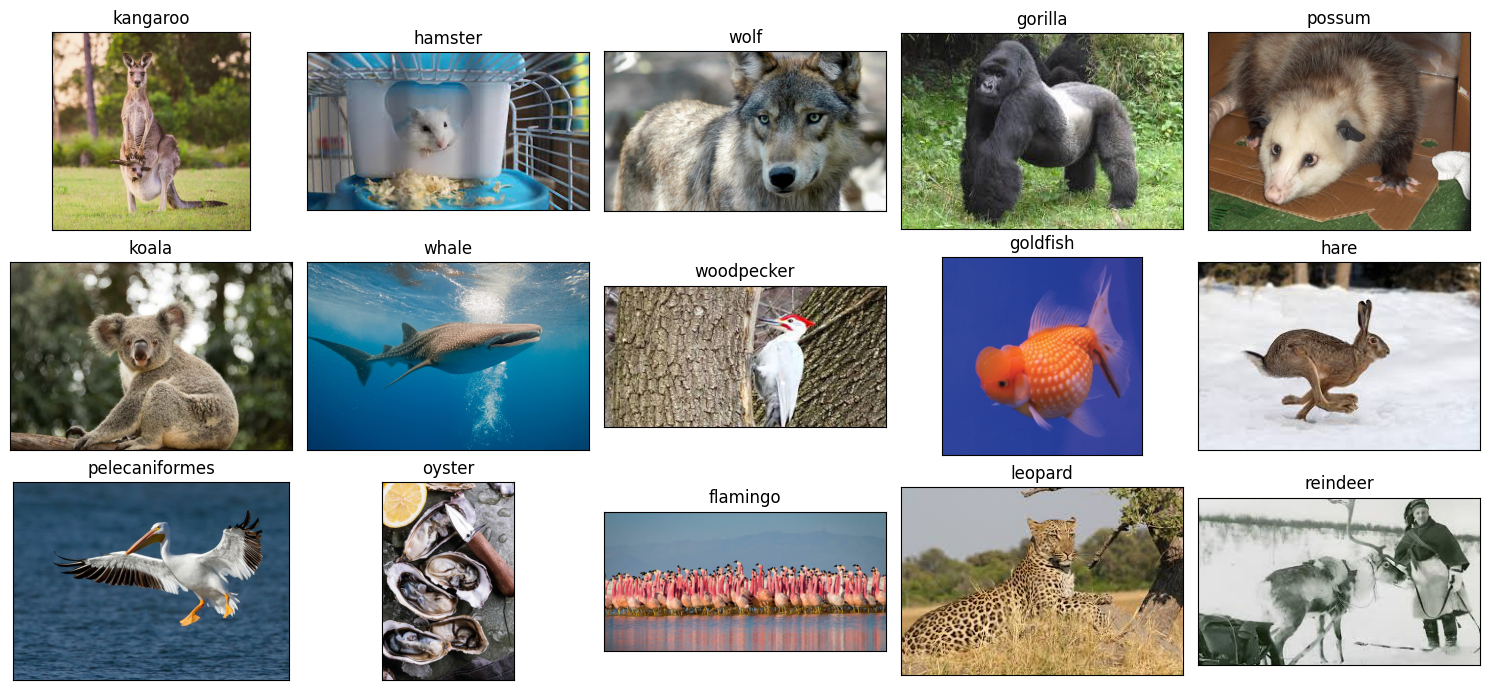

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()



---


## **Training and testing of data.**

---



In [9]:
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [10]:
train_df.shape


(4860, 2)

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_df.head(5)


,Filepath,Label
1721,/content/archive/animals/animals/ox/0e1892d5e1...,ox
349,/content/archive/animals/animals/bee/797a3a953...,bee
545,/content/archive/animals/animals/fox/9b1055345...,fox
4778,/content/archive/animals/animals/goldfish/98ef...,goldfish
701,/content/archive/animals/animals/kangaroo/0587...,kangaroo


In [13]:
    train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3888 validated image filenames belonging to 90 classes.
Found 972 validated image filenames belonging to 90 classes.
Found 540 validated image filenames belonging to 90 classes.




---


## **Creating the model.**

---



In [14]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = Input(input_shape)
    base_model = EfficientNetB1(input_shape=input_shape, include_top=False, classes=5)
    
    x = base_model(inputs)
    
    x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.1)(x)
    
    x = Dense(56, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    outputs = Dense(5, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    
    return model

In [15]:
K.clear_session()

model = create_model((224, 224, 3))
# model = load_model('models/checkpoint/EfficientNetB0.h5')

metrics = [
    'accuracy',
    'AUC'
]


27018416/27018416 [==============================] - 0s 0us/step


In [16]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=metrics)


In [17]:
checkpoint_path = 'models/EfficientNetB1/model_224.h5'

callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
]



---


## **Prediction.**

---



In [18]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

print(f'The first 5 predictions: {pred[:5]}')

17/17 [==============================] - 17s 474ms/step
The first 5 predictions: ['antelope', 'antelope', 'antelope', 'antelope', 'antelope']


In [19]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                precision    recall  f1-score   support

      antelope       0.01      1.00      0.02         5
        badger       0.00      0.00      0.00         5
           bat       0.00      0.00      0.00         4
          bear       0.00      0.00      0.00         4
           bee       0.00      0.00      0.00         4
        beetle       0.00      0.00      0.00         2
         bison       0.00      0.00      0.00         5
          boar       0.00      0.00      0.00         7
     butterfly       0.00      0.00      0.00         8
           cat       0.00      0.00      0.00         5
   caterpillar       0.00      0.00      0.00        10
    chimpanzee       0.00      0.00      0.00        11
     cockroach       0.00      0.00      0.00         4
           cow       0.00      0.00      0.00         7
        coyote       0.00      0.00      0.00         2
          crab       0.00      0.00      0.00         6
          crow       0.00      0.00      0.00  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---


## **Normalized Confusion Matrix.**

---



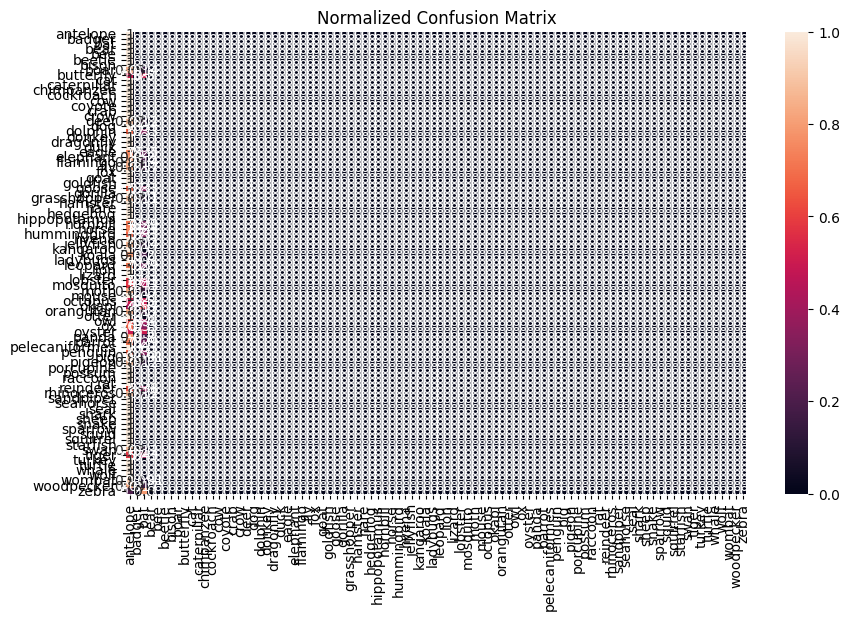

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()



---


## **Display pictures of the dataset with their labels.**

---



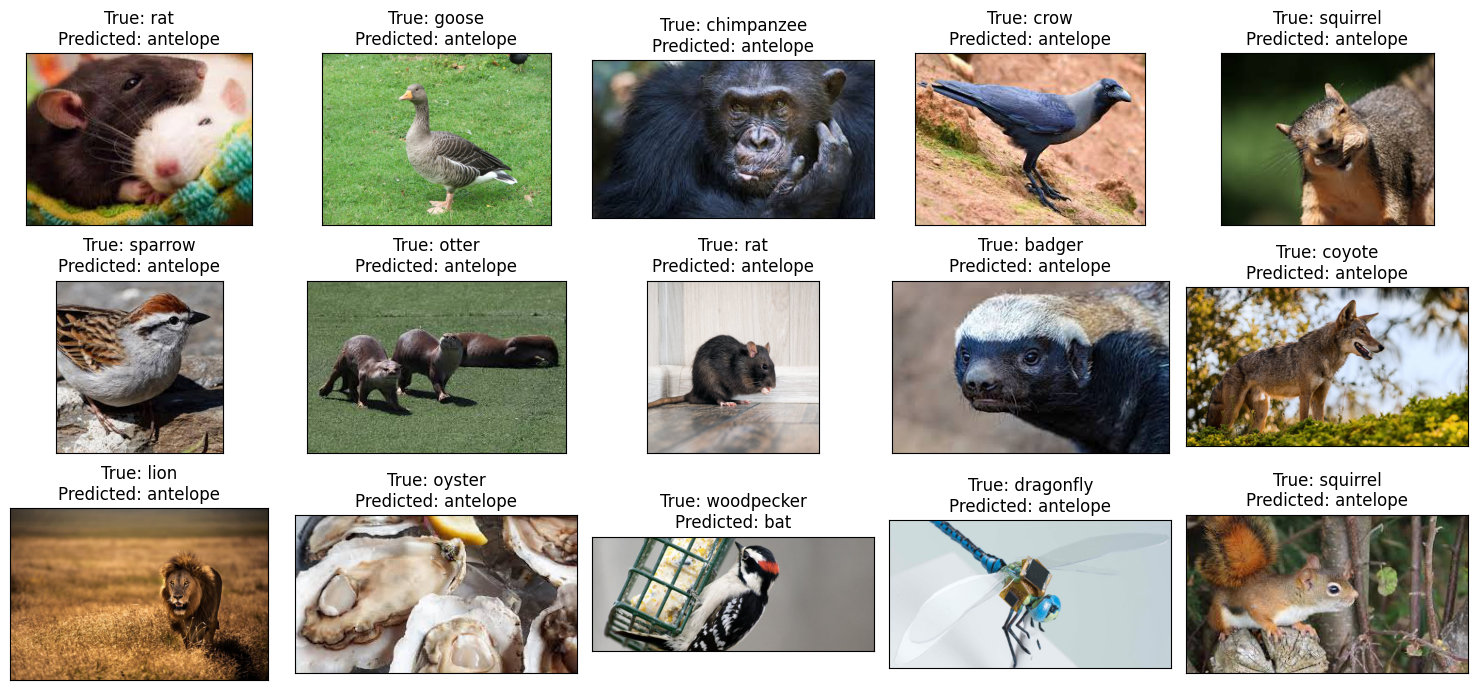

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()


# ***THANKYOU...***